# CNN and transfert learning: from MNIST to Devanagari

### Introduction

blabla

### Loading the dataset

We will use a function defined in `load_data.py`, that return the dataset as a list of PIL images and a list of labels.
Just import the file and use it:

In [1]:
import load_data
from PIL import Image

In [2]:
consonants_img, consonants_labels = load_data.PIL_list_data('consonants')
vowels_img, vowels_labels = load_data.PIL_list_data('vowels')
numerals_img, numerals_labels = load_data.PIL_list_data('numerals')

Raw consonants loaded, 7380 obs of 36 classes
Raw vowels loaded, 2652 obs of 12 classes
Raw numerals loaded, 2880 obs of 10 classes


### Exploration and pre-processing

We define a small function to easily display some charaters, randomly sampled from our dataset. We observe that the numerals are very similar to the Arab ones, but that the vowels and consonants seems more complicated and will likely be more difficult to classify. The thickness of the character is variable, but all characters are black on a white support. The images will likely need few pre-processing steps: they are already centered on the image, adjusted so they fill the entire space, and all the images have the same size and resolution. 

Some unprocessed numerals:


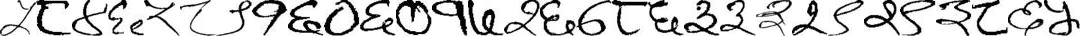

Some unprocessed vowels:


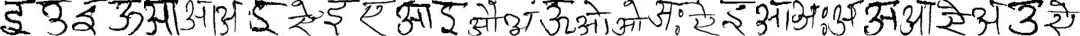

Some unprocessed consonants:


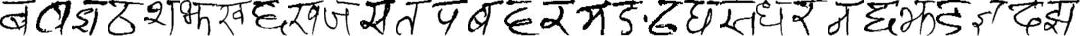

In [3]:
from IPython.display import display
from numpy import concatenate
from random import sample
from PIL import Image

def display_some(img_list, n=30, to_sample=True):
    if to_sample: 
        img_list = sample(img_list,n)
    display(Image.fromarray(concatenate(img_list,axis=1)))
    
print("Some unprocessed numerals:")
display_some(numerals_img)
print("Some unprocessed vowels:")
display_some(vowels_img)
print("Some unprocessed consonants:")
display_some(consonants_img)

Even if the images seems to be black and white, they are still RGB images. The first step is to convert these images to 'shades of greys' ones, reducing the dimension of the inputs from 36x36x3 to 36x36x1. A white pixel is represented by an integer value of 255, and a white one by a zero. Inverting the images, such as a stroke of the pen correpond to non-null values on the corresponding pixels usually leads to more stable results (It is worth noting that because we apply a PCA later, the final result is theoretically insensible to this manipulation).

Some inverted numerals:


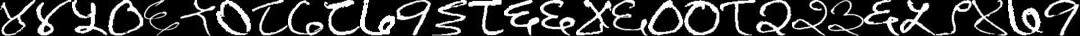

Some inverted vowels:


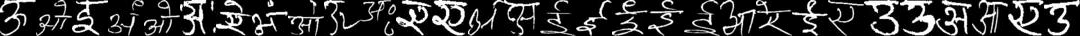

Some inverted consonants:


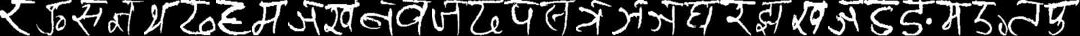

In [4]:
from PIL import ImageOps  

def pre_process(img_list):
    img_bw = [img.convert('LA') for img in img_list]
    return [ImageOps.invert(img) for img in img_list]

consonants_proc = pre_process(consonants_img)
vowels_proc = pre_process(vowels_img)
numerals_proc = pre_process(numerals_img)

print("Some inverted numerals:")
display_some(numerals_proc)
print("Some inverted vowels:")
display_some(vowels_proc)
print("Some inverted consonants:")
display_some(consonants_proc)

### Converting to tensors

In [6]:
from keras.preprocessing import image
import numpy as np

def one_img_tensor(img):
    x = image.img_to_array(img)
    # 3D tensor to 4D tensor with shape (1, nb_pixel_x, nb_pixel_y, nchannel) for stacking
    return np.expand_dims(x, axis=0)

def img_list_to_tensors(img_list):
    list_of_tensors = [one_img_tensor(img) for img in img_list]
    ref_shape = list_of_tensors[0].shape
    assert all(tens.shape == ref_shape for tens in list_of_tensors)
    return np.vstack(list_of_tensors)

tensors_numerals = img_list_to_tensors(numerals_proc).astype('float32')/255.
tensors_vowels = img_list_to_tensors(vowels_proc).astype('float32')/255.
tensors_consonants = img_list_to_tensors(consonants_proc).astype('float32')/255.

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(36, activation='softmax'))

model.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 34, 34, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               4194560   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
__________

In [30]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint  
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

def get_score_from_scratch(tensors, labels, model, epoch, batch_size, name):
    
    nb_labels = len(set(labels))
    y_all = np_utils.to_categorical([i-1 for i in np.array(labels).astype(int)], nb_labels)
    X_model, X_test, y_model, y_test = train_test_split(tensors, y_all, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, random_state=1)
    
    print("Size of the training set: {}".format(len(X_train)))
    print("Size of the validation set: {}".format(len(X_val)))
    print("Size of the testing set: {}".format(len(X_test)))

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_{}.hdf5'.format(name), 
                               verbose=1, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpointer],
             batch_size=batch_size, epochs=epoch)
    model.load_weights('saved_models/weights.best.from_scratch_{}.hdf5'.format(name))
    
    y_pred = model.predict(X_test)
    print("Accuracy on test set: {}".format(
            accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))
    return model

    

In [31]:
get_score_from_scratch(tensors_consonants, consonants_labels, model,50, 200,'consonants')

Size of the training set: 4151
Size of the validation set: 1384
Size of the testing set: 1845
Train on 4151 samples, validate on 1384 samples
Epoch 1/50
4151/4151 [==============================] - 1s - loss: 3.4616 - acc: 0.0797 - val_loss: 3.1501 - val_acc: 0.2717
Epoch 2/50
4151/4151 [==============================] - 1s - loss: 3.0214 - acc: 0.1857 - val_loss: 2.5199 - val_acc: 0.4082
Epoch 3/50
4151/4151 [==============================] - 1s - loss: 2.6815 - acc: 0.2645 - val_loss: 2.1532 - val_acc: 0.5094
Epoch 4/50
4151/4151 [==============================] - 1s - loss: 2.4270 - acc: 0.3202 - val_loss: 1.9103 - val_acc: 0.5650
Epoch 5/50
4151/4151 [==============================] - 1s - loss: 2.2013 - acc: 0.3842 - val_loss: 1.6484 - val_acc: 0.6337
Epoch 6/50
4151/4151 [==============================] - 1s - loss: 1.9920 - acc: 0.4230 - val_loss: 1.4451 - val_acc: 0.6467
Epoch 7/50
4151/4151 [==============================] - 1s - loss: 1.8418 - acc: 0.4659 - val_loss: 1.3022 -

4151/4151 [==============================] - 1s - loss: 0.7063 - acc: 0.7781 - val_loss: 0.6097 - val_acc: 0.8172
Epoch 26/50
4151/4151 [==============================] - 1s - loss: 0.6992 - acc: 0.7805 - val_loss: 0.5836 - val_acc: 0.8288
Epoch 27/50
4151/4151 [==============================] - 1s - loss: 0.7097 - acc: 0.7764 - val_loss: 0.5817 - val_acc: 0.8280
Epoch 28/50
4151/4151 [==============================] - 1s - loss: 0.6592 - acc: 0.7873 - val_loss: 0.5873 - val_acc: 0.8259
Epoch 29/50
4151/4151 [==============================] - 1s - loss: 0.6228 - acc: 0.7947 - val_loss: 0.5772 - val_acc: 0.8302
Epoch 30/50
4151/4151 [==============================] - 1s - loss: 0.6119 - acc: 0.8017 - val_loss: 0.5728 - val_acc: 0.8338
Epoch 31/50
4151/4151 [==============================] - 1s - loss: 0.5786 - acc: 0.8099 - val_loss: 0.5658 - val_acc: 0.8338
Epoch 32/50
4151/4151 [==============================] - 1s - loss: 0.5561 - acc: 0.8212 - val_loss: 0.5658 - val_acc: 0.8288
Epoc

### Pre-training on MNIST Database

In [33]:
from keras.datasets import mnist

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_train_mnist = X_train_mnist.reshape(X_train_mnist.shape[0], 28, 28, 1)
X_test_mnist = X_test_mnist.reshape(X_test_mnist.shape[0], 28, 28, 1)

X_train_mnist = X_train_mnist.astype('float32')/255.
X_test_mnist = X_test_mnist.astype('float32')/255.

y_train_mnist, y_test_mnist = np_utils.to_categorical(y_train_mnist),  np_utils.to_categorical(y_test_mnist)

In [47]:
model_mnist = Sequential()
model_mnist.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_mnist.add(Conv2D(32, (3, 3), activation='relu'))
model_mnist.add(MaxPooling2D(pool_size=(2, 2)))
model_mnist.add(Conv2D(32, (4, 4), activation='relu'))
model_mnist.add(MaxPooling2D(pool_size=(2, 2)))
model_mnist.add(Dropout(0.25))
model_mnist.add(Flatten())
model_mnist.add(Dense(256, activation='relu'))
model_mnist.add(Dropout(0.5))
model_mnist.add(Dense(10, activation='softmax'))

model_mnist.summary()
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_mnist.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 9, 9, 32)          16416     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
__________

In [48]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mnist.hdf5', 
                               verbose=1, save_best_only=True)
model_mnist.fit(X_train_mnist, y_train_mnist, validation_data=(X_test_mnist, y_test_mnist), callbacks=[checkpointer],
         batch_size=256, epochs=12)
model_mnist.load_weights('saved_models/weights.best.mnist.hdf5')

y_pred_mnist = model_mnist.predict(X_test_mnist)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test_mnist,axis=1), np.argmax(y_pred_mnist,axis=1))))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 8s - loss: 0.3032 - acc: 0.9039 - val_loss: 0.0592 - val_acc: 0.9810
Epoch 2/12
60000/60000 [==============================] - 8s - loss: 0.0921 - acc: 0.9719 - val_loss: 0.0409 - val_acc: 0.9869
Epoch 3/12
60000/60000 [==============================] - 8s - loss: 0.0668 - acc: 0.9803 - val_loss: 0.0301 - val_acc: 0.9902
Epoch 4/12
60000/60000 [==============================] - 8s - loss: 0.0533 - acc: 0.9839 - val_loss: 0.0242 - val_acc: 0.9916
Epoch 5/12
60000/60000 [==============================] - 8s - loss: 0.0444 - acc: 0.9865 - val_loss: 0.0307 - val_acc: 0.9901
Epoch 6/12
60000/60000 [==============================] - 8s - loss: 0.0389 - acc: 0.9881 - val_loss: 0.0270 - val_acc: 0.9910
Epoch 7/12
60000/60000 [==============================] - 8s - loss: 0.0361 - acc: 0.9890 - val_loss: 0.0213 - val_acc: 0.9924
Epoch 8/12
60000/60000 [==============================] - 8s 